# Neural Networks
We tried to fit a neural network to the scaled (0, 1) data, taking all the predictors (non-zero variance) as input.

After testing a few architectures for the network, we saw that the MSE was rather variable, mostly when changing training/test data, and in a lesser measure when leaving randomness only to the validation split taken for early stopping (to not overfit). To tune hyperparameters, we performed cross-validation with different training/test sets, and a compromise between lower mean MSE and lower variance was made. We also observed the behavior of the predictions on a same training set, but with different validation splits.

In [1]:
library(keras)
use_condaenv("r-tensorflow")
use_session_with_seed(1)


data <- read.csv(file.path("..", "data", "training_data.csv"))
data <- na.omit(data)
data$PL <- data$VALENCE.PLEASANTNESS
data$VALENCE.PLEASANTNESS <- NULL
data$SWEETORSOUR <- NULL
data$Intensity <- as.numeric(data$Intensity)

Set session seed to 1 (disabled GPU, CPU parallelism)



In [2]:
cols = names(data[, sapply(data, function(v) var(v) != 0)])
data <- data[,cols]
dim(data)

[1]  708 3029

In [3]:
#training and test response sets
idx <- sample(nrow(data), 4*nrow(data)/5)
data_PL <- data$PL #used later
train.y <- data$PL[idx]
test.y <- data$PL[-idx]

#scaling
data$PL <- NULL
data <- as.matrix(data)

for (i in 1:ncol(data)){
    max <- max(data[,i])
    min <- min(data[,i])
    if (max != 1 & min != 0){
        for (j in 1:nrow(data)) data[j,i] <- (data[j,i]-min) / (max-min)
    }
}

#training and test scaled predictors sets
train.x <- data[idx,]
test.x <- data[-idx,]

The testing of multiple networks (layers, neurons) was easier using a function (with small variants of what is shown here). Below are the results of our best NN-model on a random split training/test set:

In [4]:
#create NN with bootstrap data
NN_bs_predict <- function(N1, N2){
    
     nn <- keras_model_sequential() %>%
      layer_dense(units = N1, activation = 'relu', input_shape = c(3028)) %>%
      layer_dense(units = N2, activation = 'relu',) %>%
      layer_dense(units = 1, activation = 'linear')
    
        #train network
        nn %>% compile(
            loss = 'mse',
            optimizer = 'adam'  
        )
        history <- nn %>% fit(
            train.x,
            train.y,
            batch_size = 350, # stochastic gradient descent batch size
            epochs = 650,
            validation_split = 0.25,
            callbacks = callback_early_stopping(monitor = "val_loss", patience = 10)
        )
        y.pred <- predict(nn, test.x) #fixed test set
        MSE <- mean((y.pred - test.y)^2)
        c(MSE, y.pred)
}

In [5]:
res <- NN_bs_predict(600, 100) 

In [6]:
MSE <- res[1]
y.pred <- res[2:length(res)]

In [7]:
paste('MSE = ', MSE)

[1] "MSE =  442.577836558451"

The MSE is sligthly better than lasso regression, but still leaves heavy unprecisions as illustrated in the graph below:

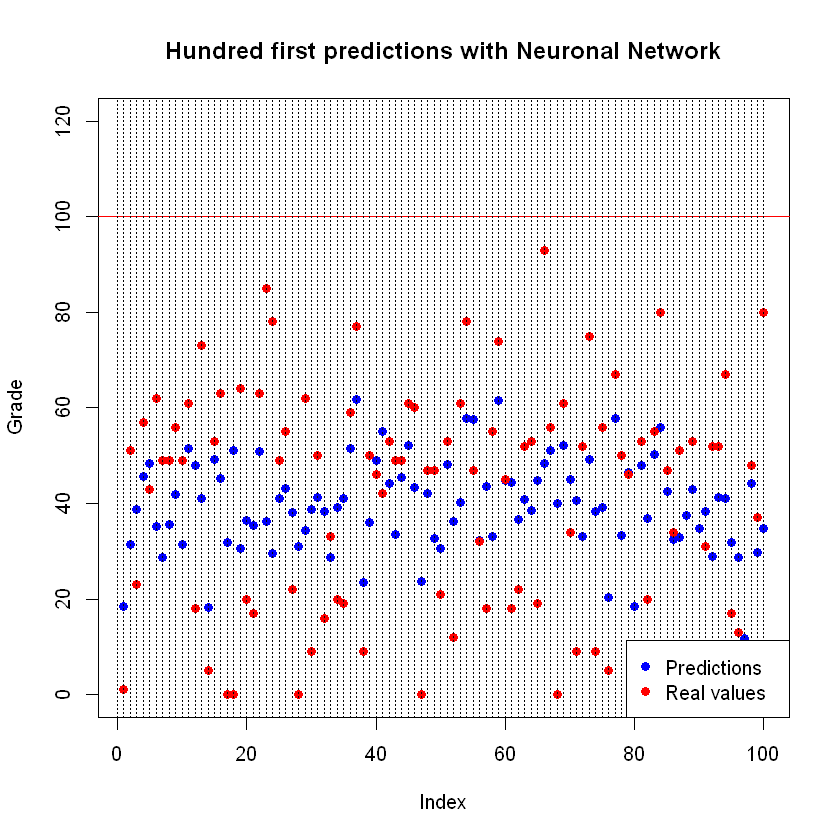

In [9]:
n = 100
plot(y.pred[1:n], col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(test.y[1:n], col = 'red', pch = 19)
title('Hundred first predictions with Neuronal Network')
abline(h = 100, col = 'red')
for(i in seq(0, n, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)

The best improvement compared to linear regression is that the predicted responses are much more spread away from the mean.

# JUSTIFICATION
We applied cross-validation to show the mean MSE and variance of the parameters combinations, elements that are taken into account for the choice of the model.
We also demonstrate that the variability of the MSE given different validation sets taken in the same training/set is not significant for choosing the model.

## Cross-Validation, parameters combinations variance

In [10]:
MSEs <- c()

for (N1 in c(1000, 600, 300)){
    for (N2 in c(600, 300, 100)){
        res <- c()
        #create architecture
        nn <- keras_model_sequential() %>%
            layer_dense(units = N1, activation = 'relu', input_shape = c(3028)) %>%
            layer_dense(units = N2, activation = 'relu',) %>%
            layer_dense(units = 1, activation = 'linear')
        
    for (i in 1:20){
        set.seed(i)
        #create different sets each turn
        idx <- sample(nrow(data), 4*nrow(data)/5)
        train.y <- data_PL[idx]
        test.y <- data_PL[-idx]
        train.x <- data[idx,]
        test.x <- data[-idx,]
        
        #train network
        nn %>% compile(
            loss = 'mse',
            optimizer = 'adam'  
        )
        history <- nn %>% fit(
            train.x,
            train.y,
            batch_size = 350, # stochastic gradient descent batch size
            epochs = 650,
            validation_split = 0.25,
            callbacks = callback_early_stopping(monitor = "val_loss", patience = 10)
        )
        #compute MSE
        y.pred <- predict(nn, test.x) #fixed test set
        MSE <- mean((y.pred - test.y)^2)
        res <- c(res, MSE)
        }
    #store cross-validated MSEs for each parameter combination
    MSEs <- rbind(MSEs, res)
    }
}

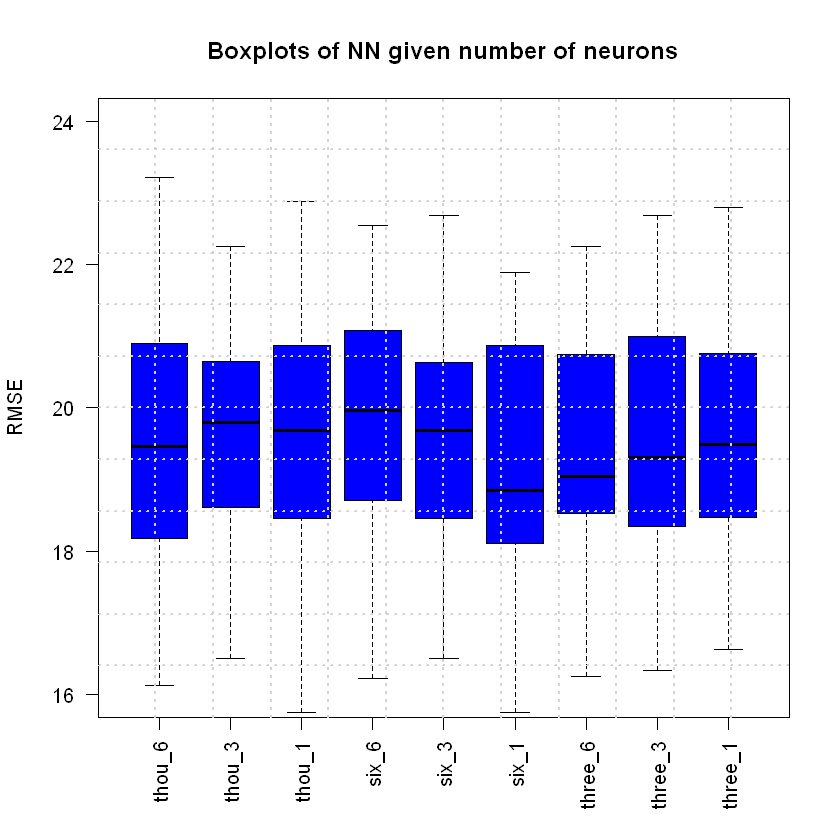

In [19]:
RMSEs <- MSEs**0.5
to_plot <- data.frame(thou_6 = RMSEs[1,], thou_3 = RMSEs[2,], thou_1 = RMSEs[3,],
                     six_6 = RMSEs[4,], six_3 = RMSEs[5,], six_1 = RMSEs[6,],
                     three_6 = RMSEs[7,], three_3 = RMSEs[8,], three_1 = RMSEs[9,])
boxplot(to_plot, ylab = "RMSE",  col = 'blue', ylim = c(16, 24), las = 2)
title('Boxplots of NN given number of neurons')
grid(12, lw = 2)

We see that most configurations have comparable variance throughout training/test sets, with notably a better score for a configuration of 2 layers, 600 and 100 neurons respectively, which is the one we chose.

## Validation split variance

In [12]:
each_result <- c()
mean_MSE <- c()

for (N1 in c(1000, 600, 300)){
     for (N2 in c(600, 300, 100)){
         all.MSE <- c()
         for (i in 1:10){
            res_ <- NN_bs_predict(N1, N2)
            MSE <- res_[1]
            each_result <- rbind(each_result, c(N1, N2, MSE))
            all.MSE <- c(all.MSE, MSE)
        }
        mean_MSE <- rbind(mean_MSE, c(N1, N2, mean(all.MSE)))
    }
}

In [13]:
each_result <- data.frame(N1 = each_result[,1], N2 = each_result[,2], MSE = each_result[,3])
mean_MSE <- data.frame(N1 = mean_MSE[,1], N2 = mean_MSE[,2], MSE = mean_MSE[,3])

In [14]:
print("Individual results on each trial given particular parameters")
print(each_result)

[1] "Individual results on each trial given particular parameters"
     N1  N2      MSE
1  1000 600 525.2761
2  1000 600 526.5681
3  1000 600 517.2698
4  1000 600 538.3980
5  1000 600 530.5105
6  1000 600 517.5046
7  1000 600 526.0032
8  1000 600 508.7869
9  1000 600 521.9837
10 1000 600 532.8831
11 1000 300 508.0445
12 1000 300 522.7490
13 1000 300 529.8676
14 1000 300 516.9711
15 1000 300 524.9786
16 1000 300 520.4796
17 1000 300 516.1250
18 1000 300 540.0180
19 1000 300 533.6941
20 1000 300 539.7748
21 1000 100 528.1331
22 1000 100 511.2316
23 1000 100 532.6563
24 1000 100 522.9322
25 1000 100 520.1459
26 1000 100 535.9471
27 1000 100 519.4431
28 1000 100 529.0644
29 1000 100 543.9004
30 1000 100 523.2628
31  600 600 504.3359
32  600 600 530.8842
33  600 600 508.8999
34  600 600 530.3565
35  600 600 520.5148
36  600 600 522.2728
37  600 600 506.4048
38  600 600 539.3249
39  600 600 514.7110
40  600 600 519.2061
41  600 300 524.2843
42  600 300 527.3074
43  600 300 538.5684
44  600 3

We can observe that the MSE varies a bit given the validation set for each hyperparameter combination.

[1] "Mean MSE for each configuration"
    N1  N2      MSE
1 1000 600 524.5184
2 1000 300 525.2702
3 1000 100 526.6717
4  600 600 519.6911
5  600 300 522.3318
6  600 100 526.3709
7  300 600 519.6289
8  300 300 523.5911
9  300 100 522.9300


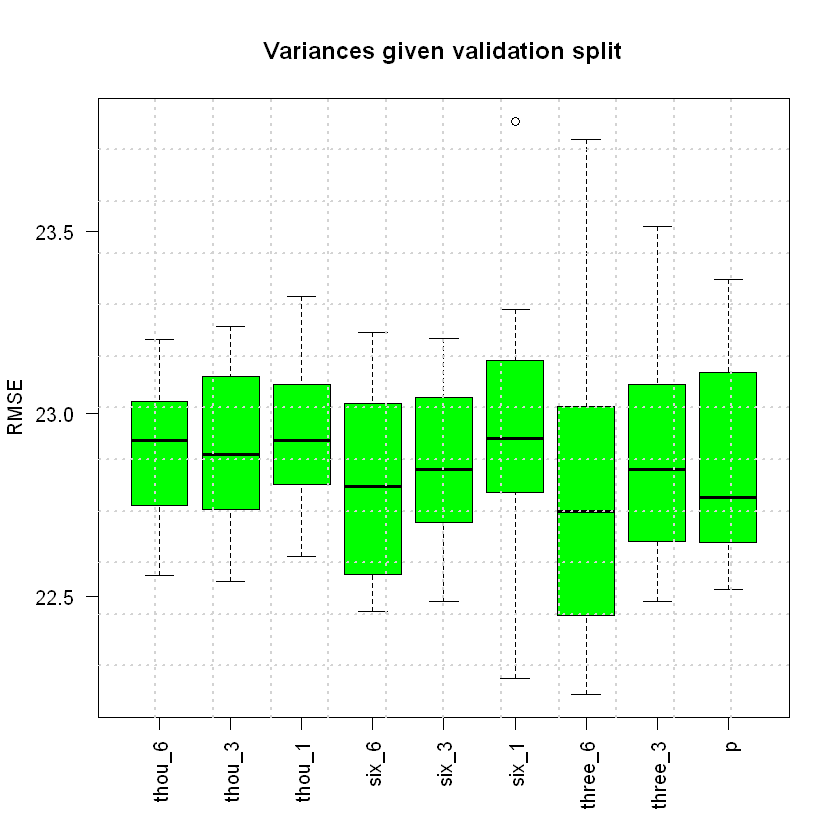

In [20]:
print("Mean MSE for each configuration")
print(mean_MSE)
p <- each_result$MSE**0.5
vars <- data.frame(thou_6 = p[1:10], thou_3 = p[11:20], thou_1 = p[21:30],
                     six_6 = p[31:40], six_3 = p[41:50], six_1 = p[51:60],
                     three_6 = p[61:70], three_3 = p[71:80], p = p[81:90])
boxplot(vars, ylab = "RMSE",  col = 'green', las = 2)
title('Variances given validation split')
grid(12, lw = 2)

When comparing the MSE and variances on this particular training set, we observe that the variance due to the validation split is comparable between most methods, and does not constitute a bias when choosing the model. It also illustrate that the method we chose actually can give pretty bad results on particular splits.